In [1]:
import gymnasium as gym
import cv2
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image
import numpy as np
from util import *
import random
# Create the environment with the grayscale observation type
env = gym.make("ALE/Assault-v5", obs_type="grayscale")
obs, info = env.reset()

In [3]:
def get_iou_score(obj1, obj2):
    """
    Calculate a modified IOU score for grayscale images, accounting for intensity overlap.
    Args:
        obj1: First grayscale image (2D numpy array).
        obj2: Second grayscale image (2D numpy array).
    Returns:
        iou: Modified Intersection over Union (IOU) score for grayscale images.
    """
    # Get the shapes of both objects
    shape1 = obj1.shape
    shape2 = obj2.shape

    # Calculate the required padding for each dimension
    pad_x1 = max(0, shape2[0] - shape1[0])  # Padding for obj1 along x-axis
    pad_x2 = max(0, shape1[0] - shape2[0])  # Padding for obj2 along x-axis
    pad_y1 = max(0, shape2[1] - shape1[1])  # Padding for obj1 along y-axis
    pad_y2 = max(0, shape1[1] - shape2[1])  # Padding for obj2 along y-axis

    # Apply padding to obj1 and obj2
    obj1_padded = np.pad(obj1, ((0, pad_x1), (0, pad_y1)), mode='constant', constant_values=0)
    obj2_padded = np.pad(obj2, ((0, pad_x2), (0, pad_y2)), mode='constant', constant_values=0)

    # Ensure the padded shapes match
    assert obj1_padded.shape == obj2_padded.shape, "Shapes do not match after padding."

    # Calculate Intersection (minimum intensity at each point)
    intersection = np.sum(np.minimum(obj1_padded, obj2_padded))
    
    # Calculate Union (maximum intensity at each point)
    union = np.sum(np.maximum(obj1_padded, obj2_padded))

    # Compute IOU
    iou = intersection / union if union > 0 else 0.0
    return iou

In [36]:
# for each object in f1, find its best match in f2
def get_matches(f1, f2):
    f1_objects = detect_objects(f1, display=False)
    f2_objects = detect_objects(f2, display=False)
    matches = {}

    for i in f1_objects:
        obj, loc = i
        o1_area = obj.shape[0] * obj.shape[1]
        x, y, h, w = loc
        hashable_obj = tuple(map(tuple, obj))
        matches[hashable_obj] = []

        for j in f2_objects:
            obj2, loc2 = j
            o2_area = obj2.shape[0] * obj2.shape[1]
            area_diff = area_compare(o1_area, o2_area)
            if area_diff > 2:
                continue
            x2, y2, h2, w2 = loc2
            if np.array_equal(obj, obj2) and loc == loc2:
                # Remove obj1 key from matches
                matches.pop(hashable_obj)
                break
            iou_score = get_iou_score(obj, obj2)
            distance = np.sqrt((x - x2) ** 2 + (y - y2) ** 2)
            if iou_score > 0.3 and distance < 100:
                matches[hashable_obj].append((obj2, iou_score, distance, loc, loc2))  # Include bounding boxes

    # Now filter and assign matches
    final_matches = {}
    used_f2_objects = set()
    bounding_box_matches = []

    for f1_obj, candidates in matches.items():
        # Sort candidates by distance first, and then by IOU score
        candidates = sorted(candidates, key=lambda x: (x[2], -x[1]))  # Sort by distance (ascending) and IOU (descending)

        for candidate in candidates:
            obj2, iou_score, distance, loc1, loc2 = candidate
            # Convert obj2 to a hashable representation
            hashable_obj2 = tuple(map(tuple, obj2))

            # Ensure the object in frame2 hasn't already been assigned
            if hashable_obj2 not in used_f2_objects:
                final_matches[f1_obj] = (obj2, iou_score, distance)
                bounding_box_matches.append((loc1, loc2))  # Store bounding box pairs
                used_f2_objects.add(hashable_obj2)  # Mark this object as used
                break

    print(f"Total matches: {len(final_matches)}")
    return final_matches, bounding_box_matches


In [37]:
f1 = cv2.imread("f1.png", cv2.IMREAD_GRAYSCALE)
f2 = cv2.imread("f2.png", cv2.IMREAD_GRAYSCALE)

In [38]:
final_matches, bounding_box_matches = get_matches(f1,f2)

Total matches: 5


In [40]:
def unhash_obj(obj):
    return np.array(obj)

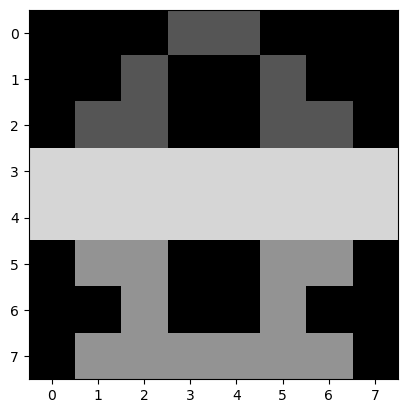

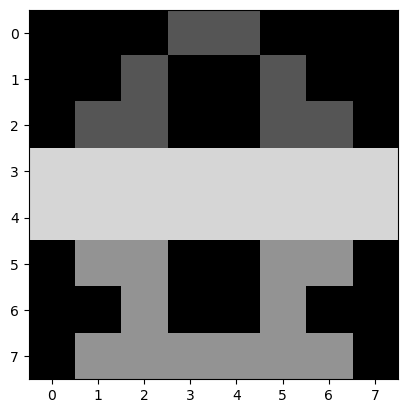

1.0


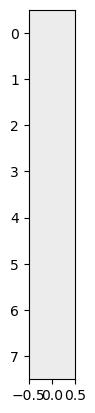

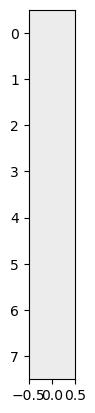

1.0


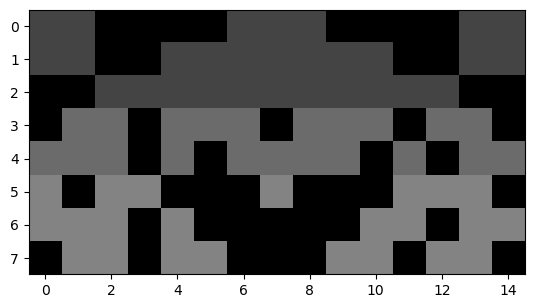

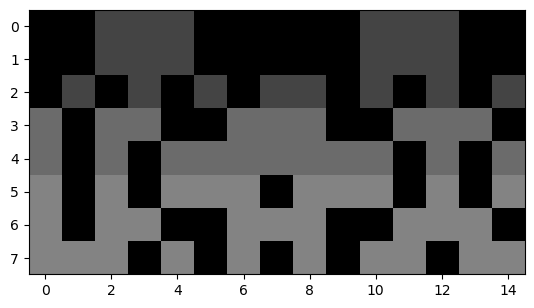

0.31812409288824384


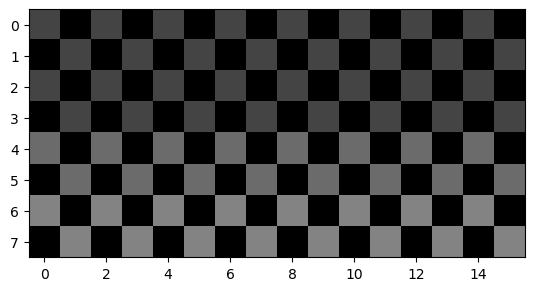

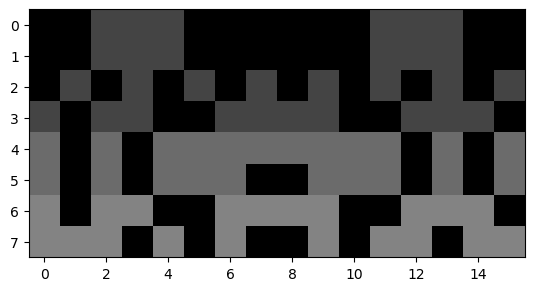

0.32214423761570543


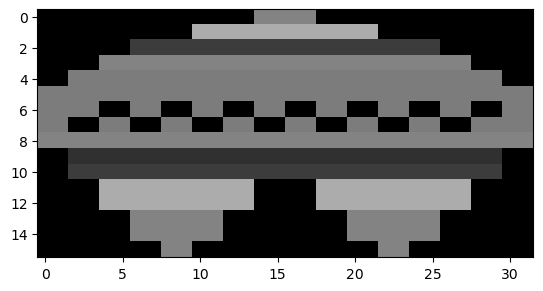

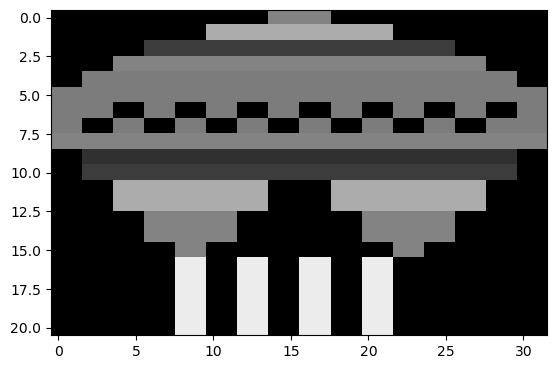

0.7953343161911369


In [41]:
for key, value in final_matches.items():
    imshow(unhash_obj(key))
    imshow(unhash_obj(value[0]))
    print(get_iou_score(unhash_obj(key), unhash_obj(value[0])))
    #print(value[1])
    #break

In [73]:
def transition_imshow(f1,f2):
    #display f1 and f2 side by side
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(f1, cmap='gray')
    plt.title("Frame 1")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(f2, cmap='gray')
    plt.title("Frame 2")
    plt.axis('off')
    plt.show()

In [74]:
f1 = cv2.imread("f1.png")
f2 = cv2.imread("f2.png")

In [75]:
def visualize_bounding_box_matches(frame1,frame2,bounding_box_matches):
    #for each bounding box match 
        #display f1 and f2 side by side, with a red rectangle around the bounding box
    for i in bounding_box_matches:
        f1_obj, f2_obj = i
        f1_x, f1_y, f1_w, f1_h = f1_obj
        f2_x, f2_y, f2_w, f2_h = f2_obj
        image_1 = frame1.copy()
        image_2 = frame2.copy()
        image_1 = cv2.rectangle(image_1, (f1_x, f1_y), (f1_x+f1_w, f1_y+f1_h), (255, 0, 0), 2)
        image_2 = cv2.rectangle(image_2, (f2_x, f2_y), (f2_x+f2_w, f2_y+f2_h), (255, 0, 0), 2)
        transition_imshow(image_1,image_2)
        #clear image_1 and image_2


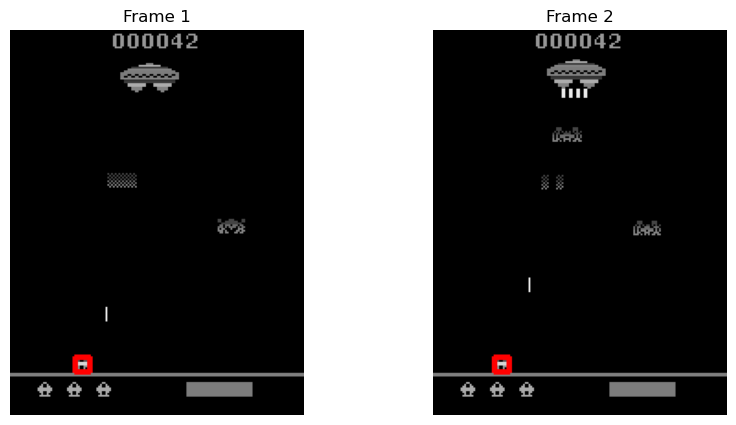

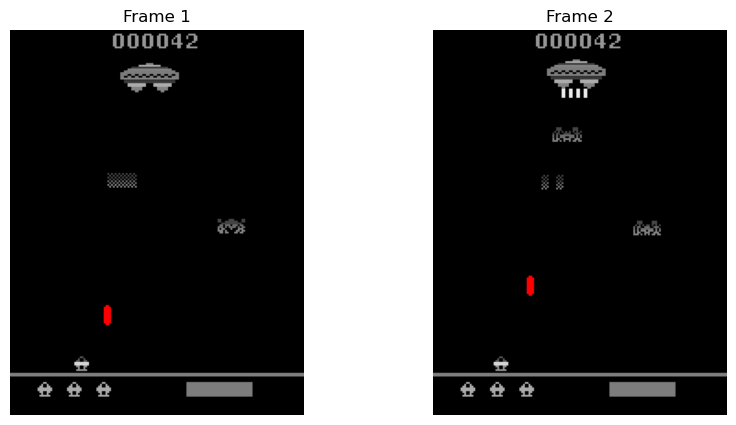

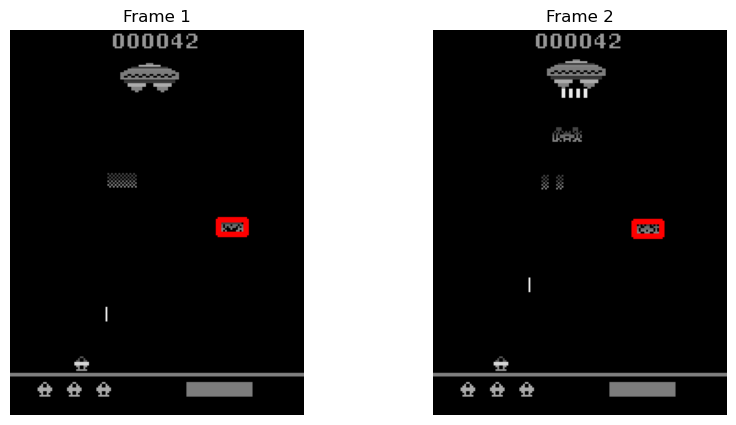

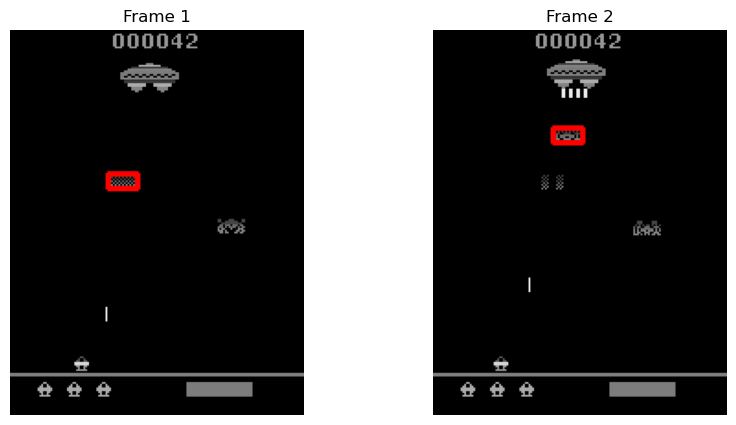

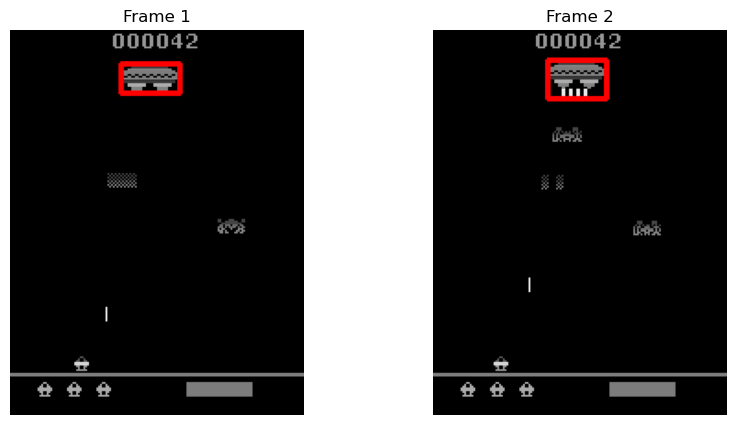

In [76]:
visualize_bounding_box_matches(f1,f2,bounding_box_matches)

In [77]:
#generate a list of N f1,f2 pairs by taking random actions
def generate_random_transitions(env, N):
    transitions = []
    for i in range(N):
        action = env.action_space.sample()
        f1, _, _, _,_ = env.step(action)
        f2, _, _, _,_ = env.step(action)
        transitions.append((f1,f2))
    return transitions

train_data = generate_random_transitions(env, 10)

In [80]:
train_bounding_boxes = []
for i in train_data:
    f1, f2 = i
    matches, bounding_boxes = get_matches(f1,f2)
    train_bounding_boxes.append([f1,f2,bounding_boxes])

Total matches: 2
Total matches: 3
Total matches: 3
Total matches: 4
Total matches: 6
Total matches: 6
Total matches: 3
Total matches: 4
Total matches: 4
Total matches: 4


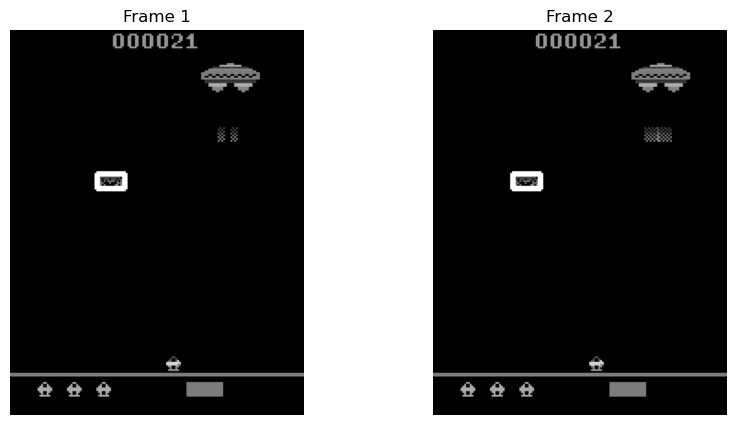

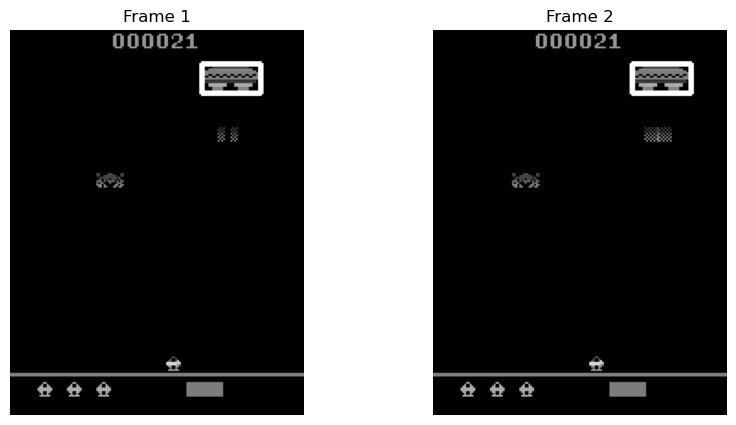

-*************************************************************************************************


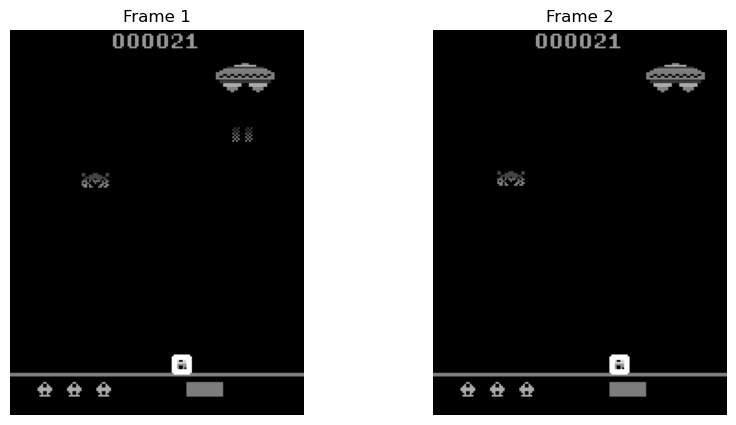

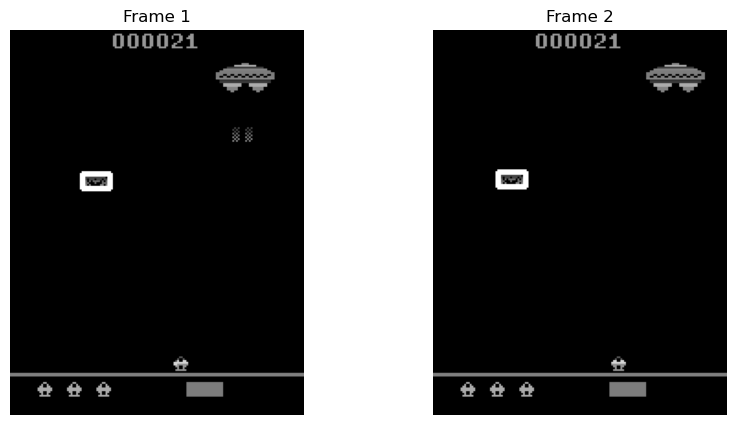

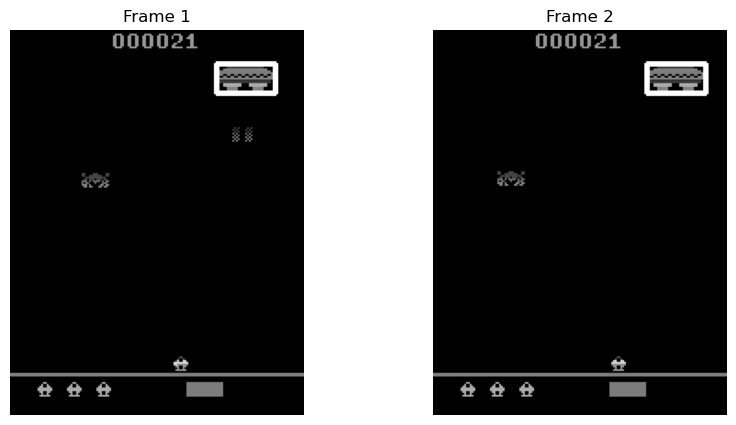

-*************************************************************************************************


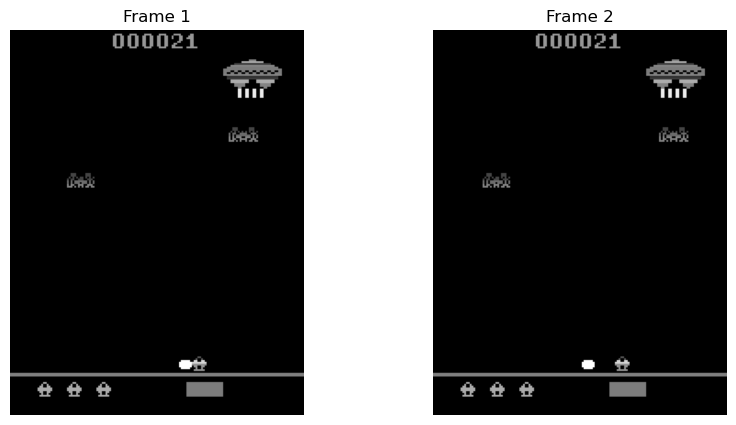

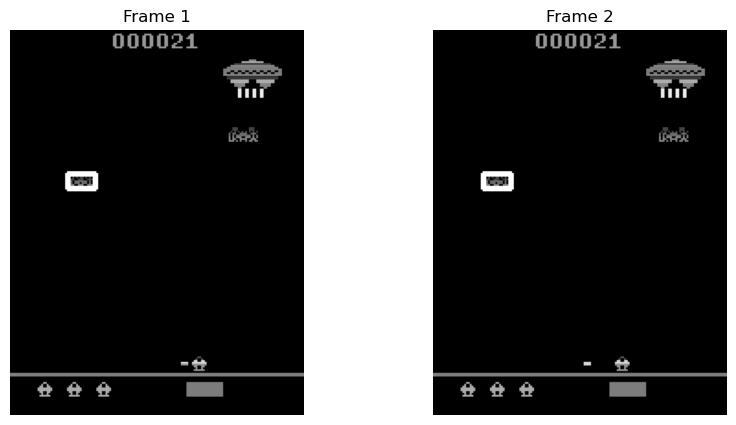

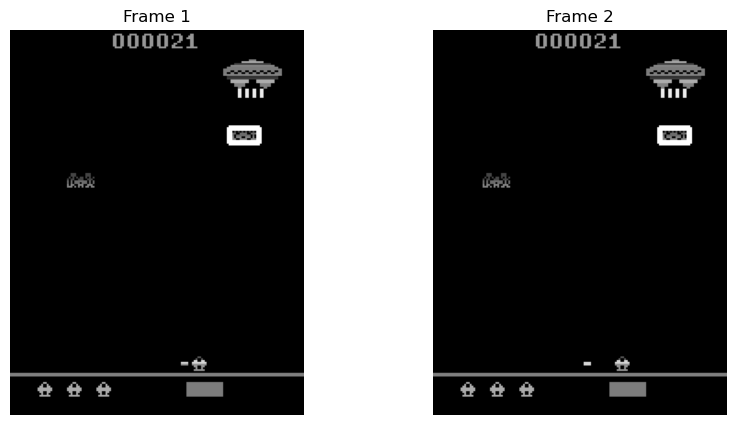

-*************************************************************************************************


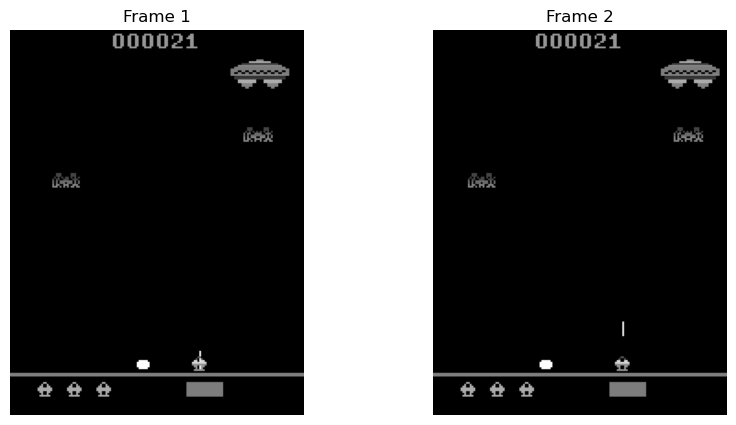

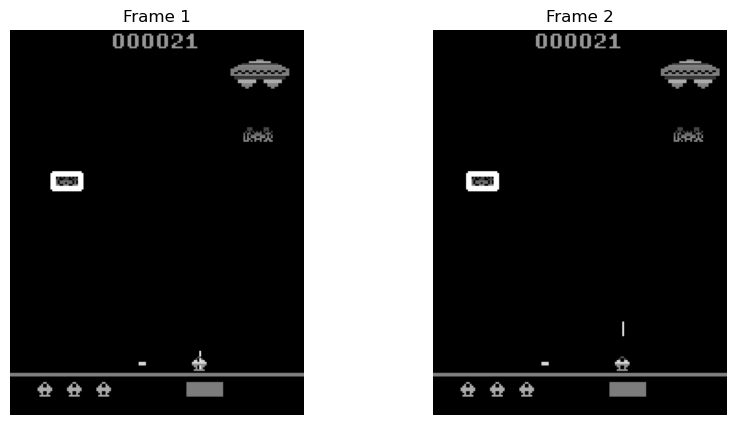

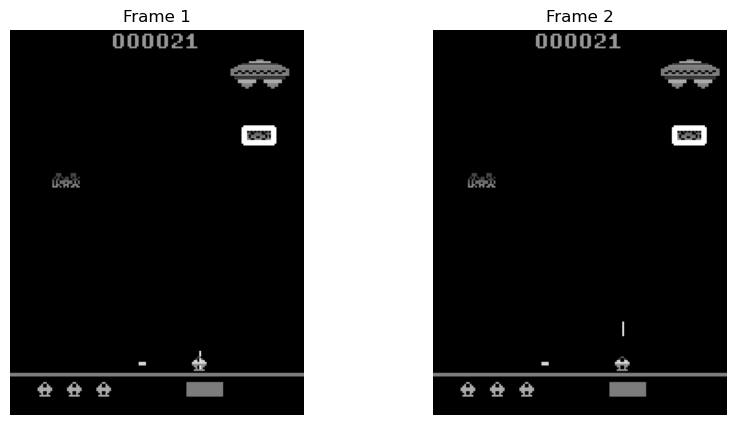

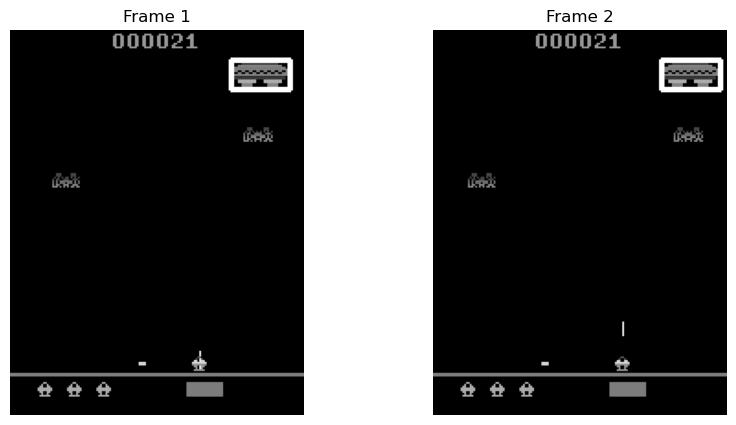

-*************************************************************************************************


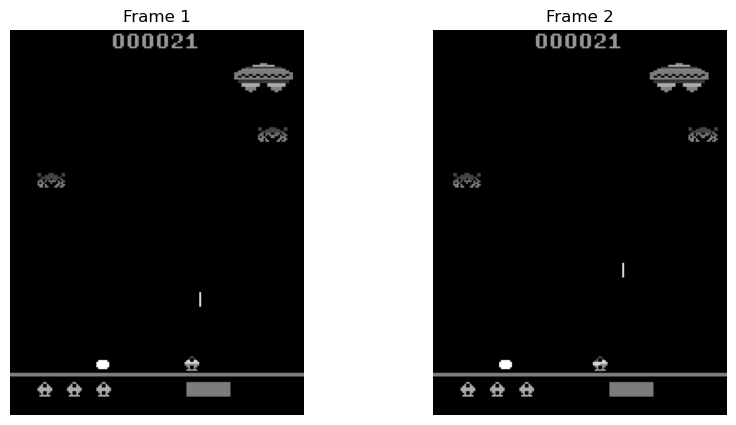

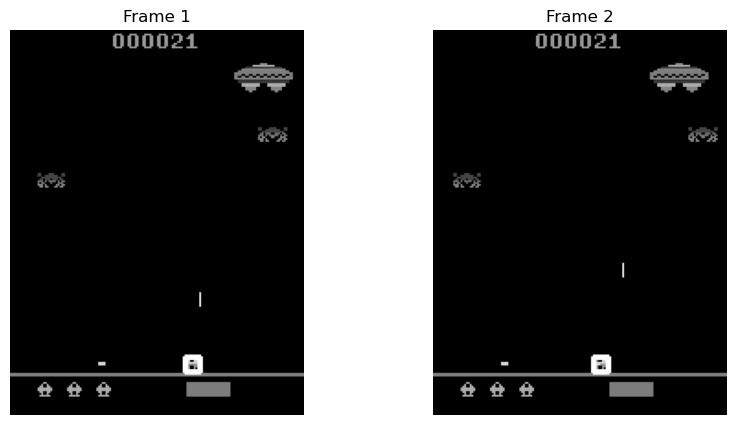

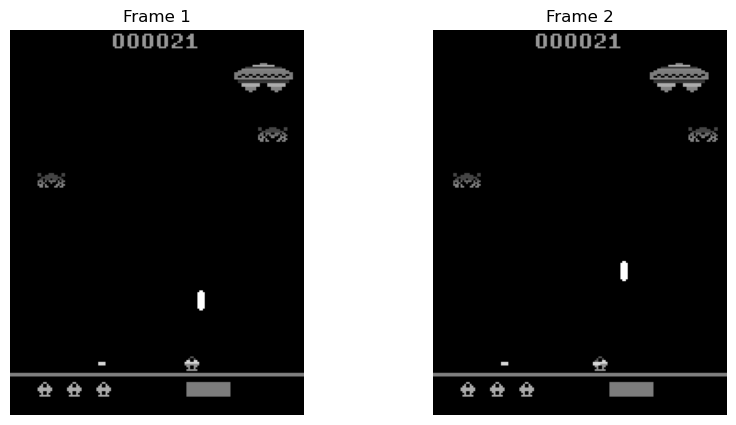

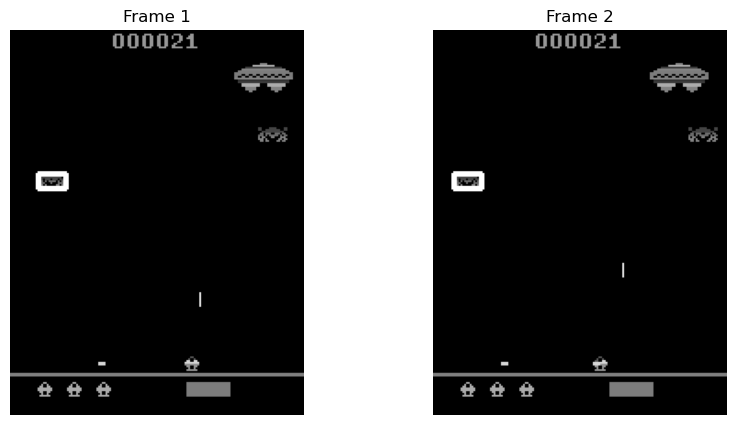

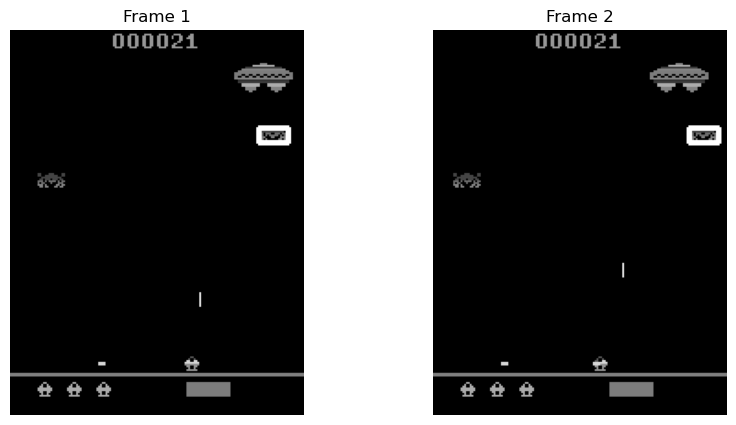

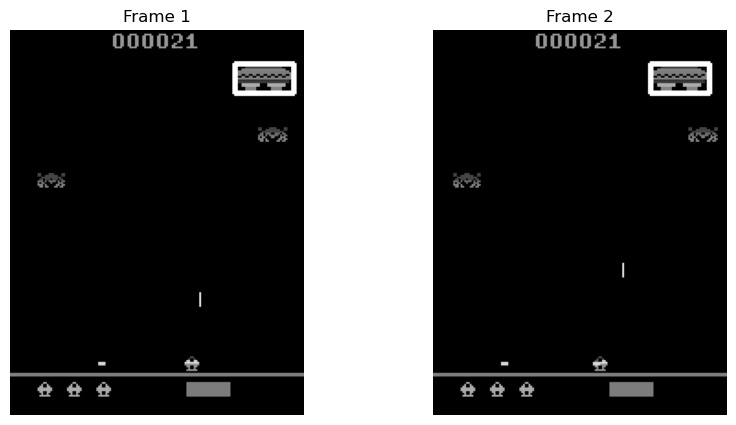

-*************************************************************************************************


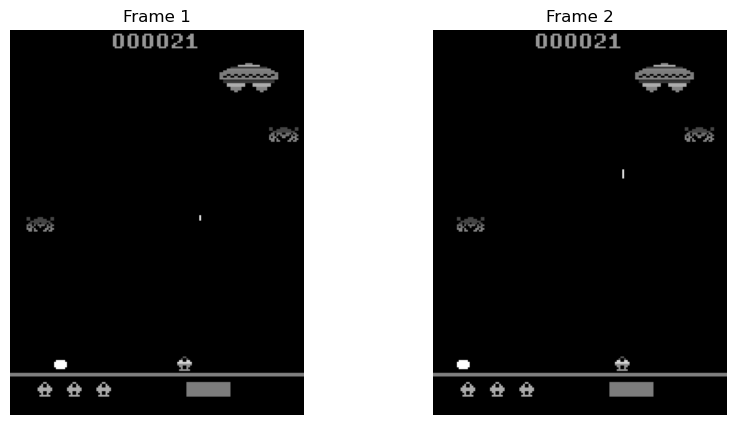

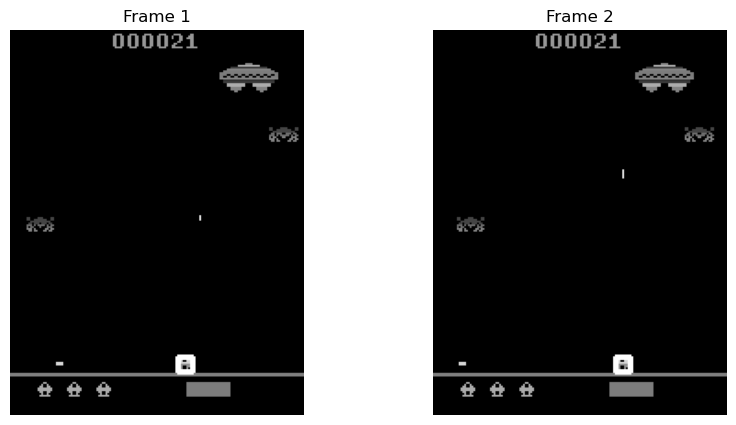

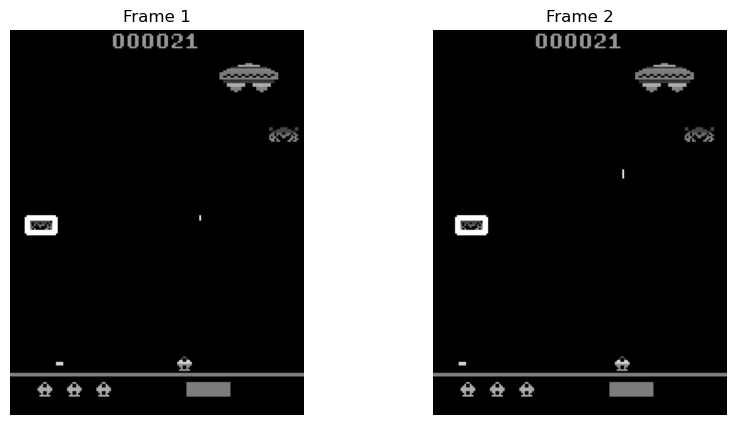

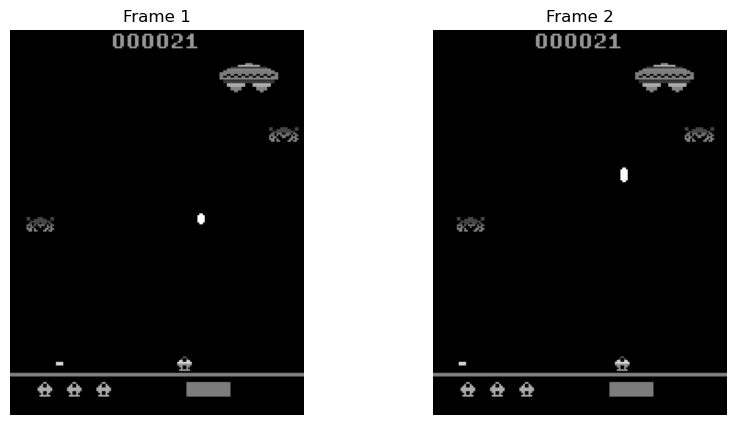

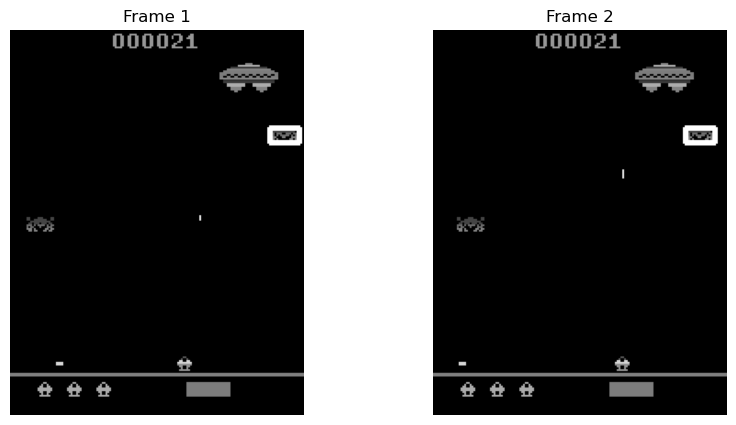

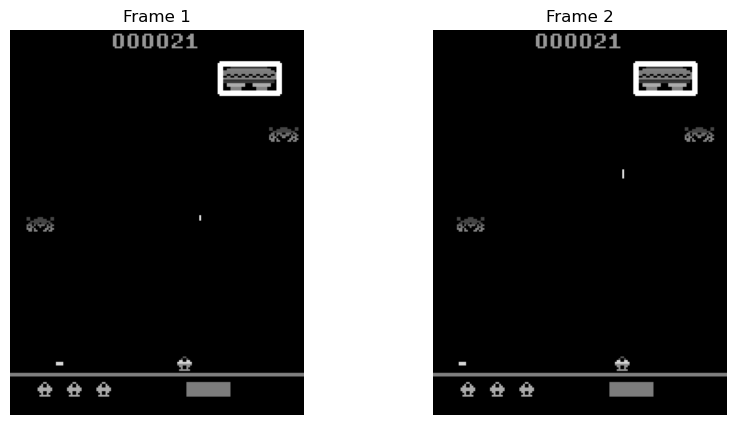

-*************************************************************************************************


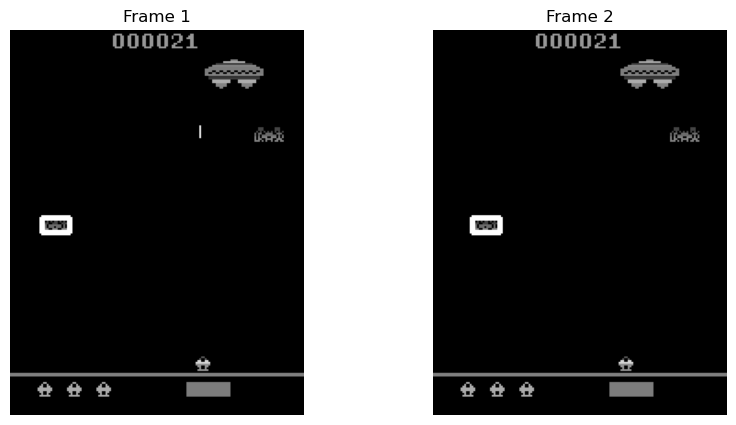

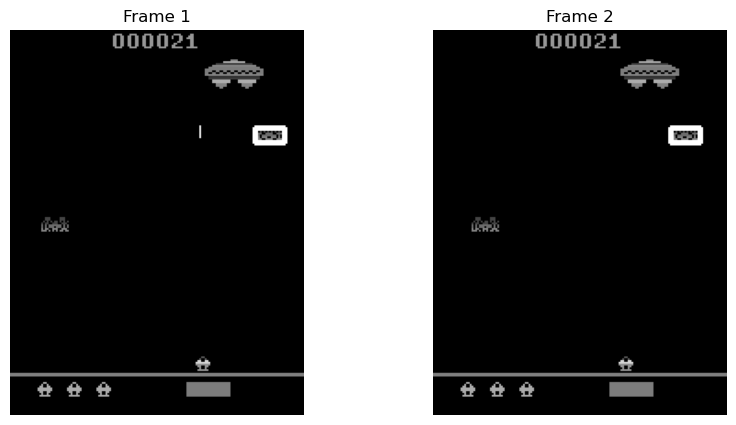

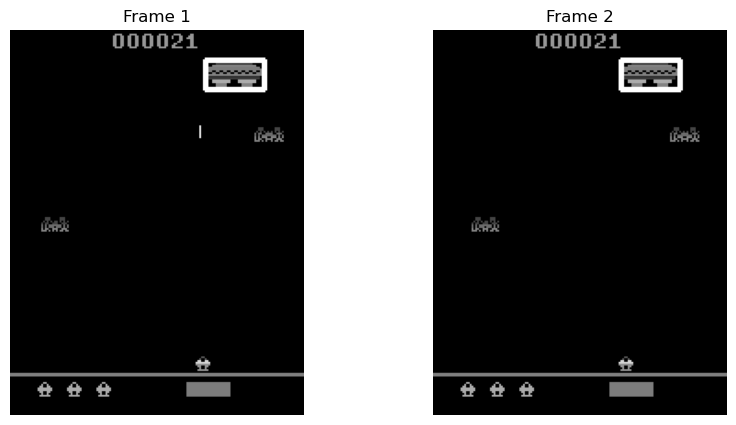

-*************************************************************************************************


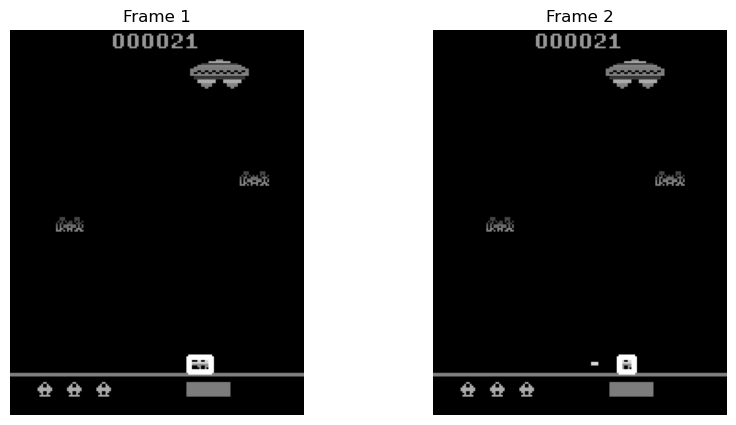

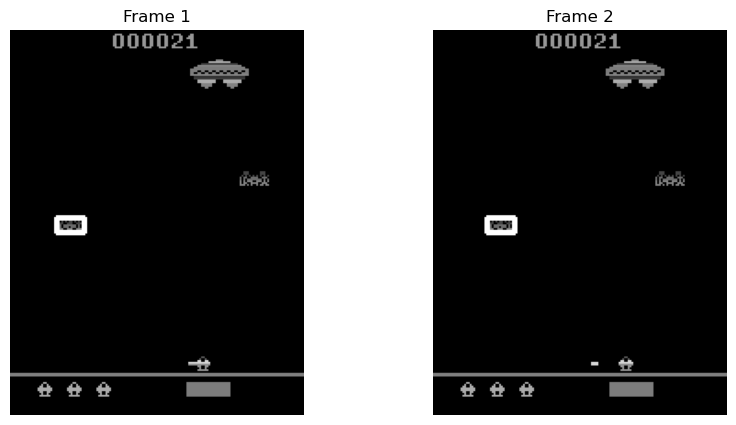

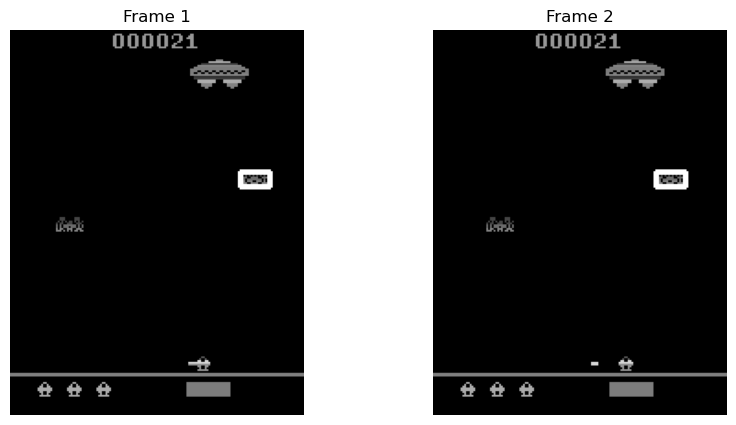

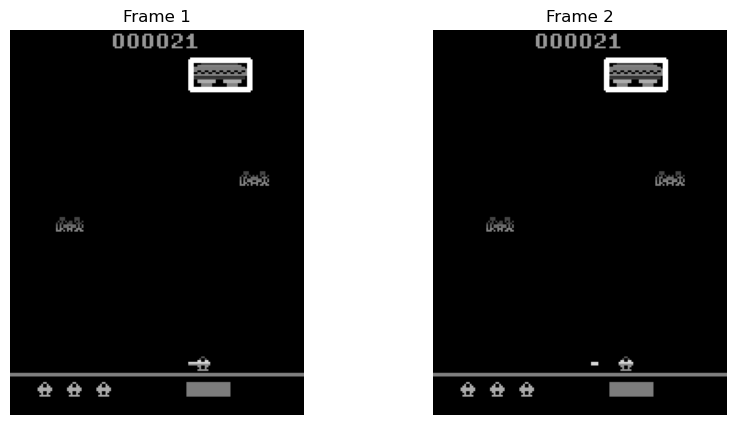

-*************************************************************************************************


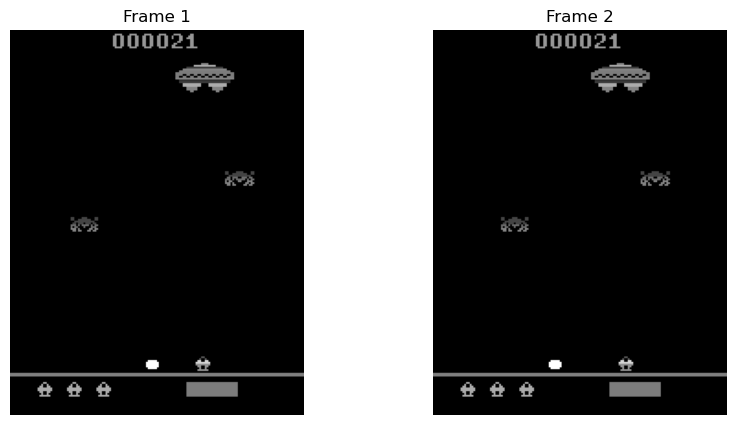

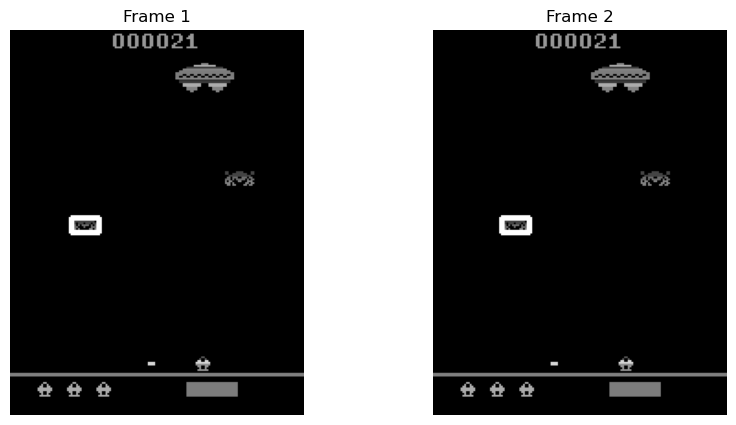

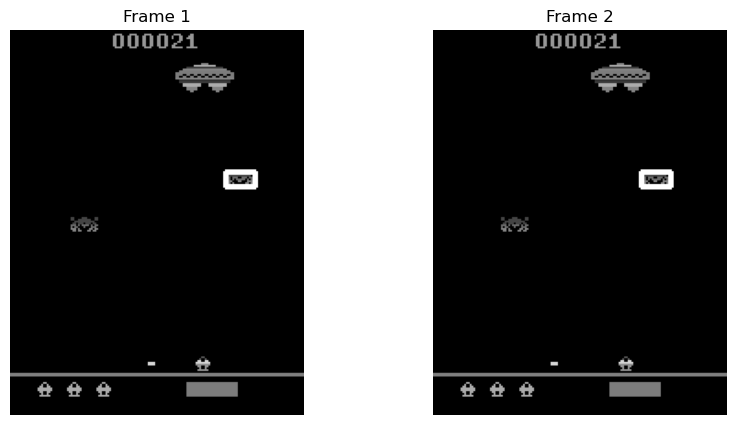

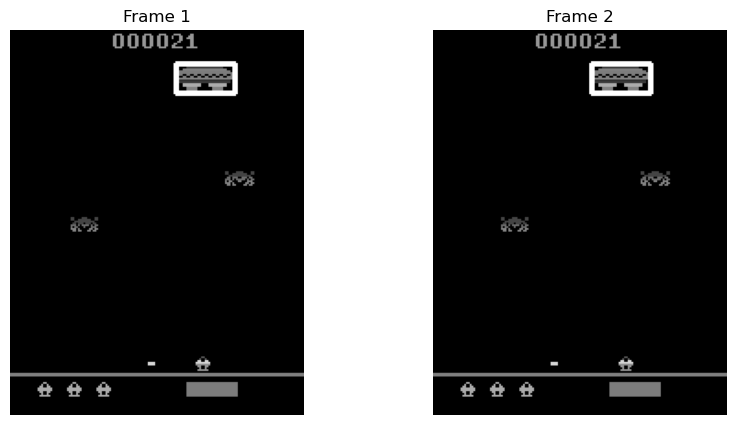

-*************************************************************************************************


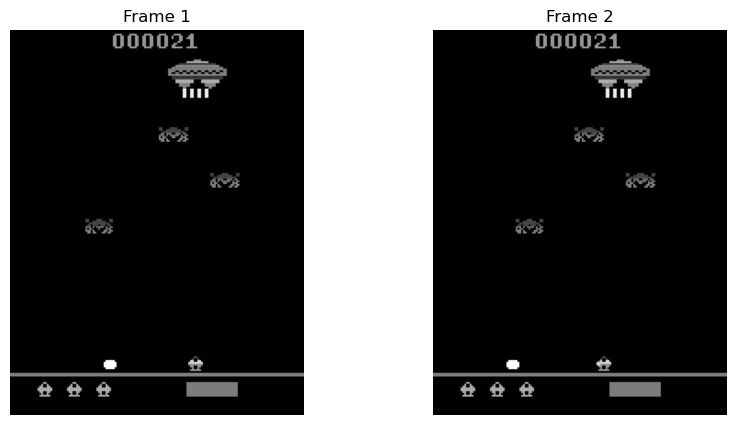

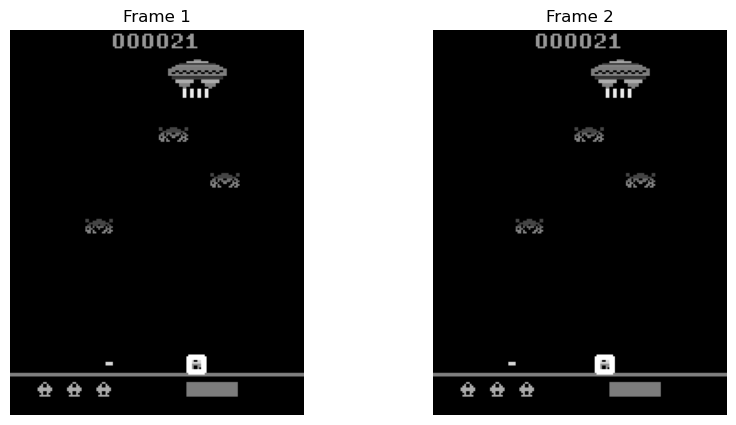

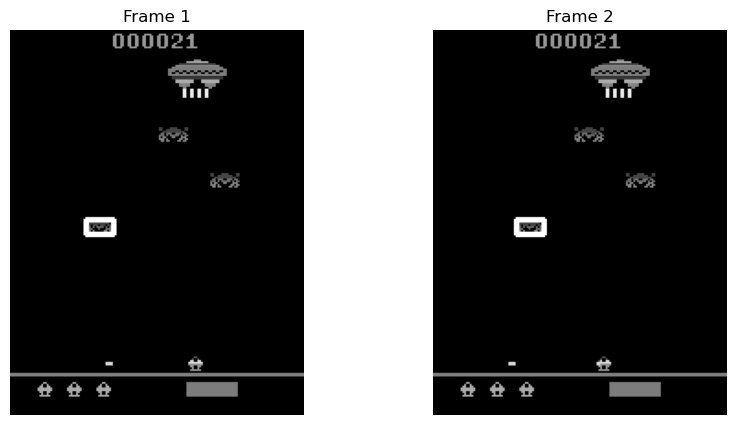

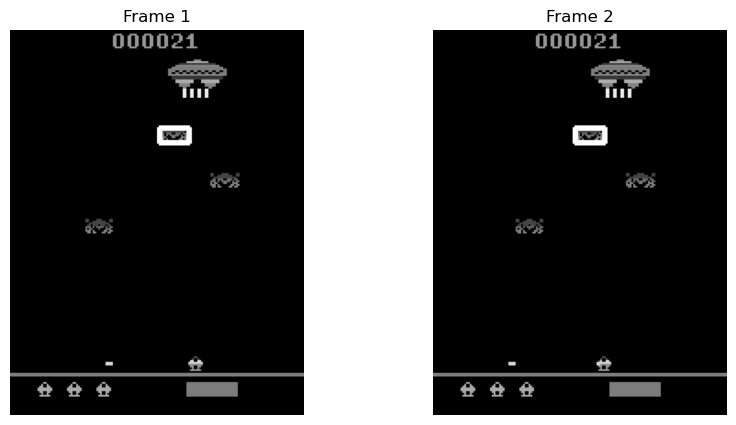

-*************************************************************************************************


In [81]:
#visualize all
for i in train_bounding_boxes:
    f1, f2, bounding_boxes = i
    visualize_bounding_box_matches(f1,f2,bounding_boxes)
    print("-*************************************************************************************************")